## Entity detection - Frame

In [8]:
#%load_ext autoreload
#%autoreload 2
#
#from frames import get_frame
#from google_detect import ObjectDetector
#from config import Config
#
#frame = get_frame(minute=Config.minute, second=Config.second)
#
#first =  ObjectDetector()
#result = first.detect_and_visualize(image_path=Config.image_path, 
#                          text_queries=Config.texts,
#                           threshold=0.3)

# Entity Tracking

In [9]:
#%load_ext autoreload
#%autoreload 2
#
#from tracking import VideoTracker
#from clip import extract_clip_and_frame
#from config import Config
#import os
#
#clip_path, _ = extract_clip_and_frame(video_path=Config.video_path,
#                             event_minute=Config.minute,
#                             event_second=Config.second)
#                             
#
#tracker = VideoTracker()
#
#output_video_path = os.path.join(Config.output_clip_dir, "tracked_" + Config.output_name)
#
#tracking_results = tracker.process_video(
#    clip_path, 
#    output_video_path,
#)
#
#total_tracks = sum(len(frame_data['tracks']) for frame_data in tracking_results)
#avg_tracks_per_frame = total_tracks / len(tracking_results) if tracking_results else 0
#
#print(f"- Promedio de tracks por frame: {avg_tracks_per_frame:.1f}")
#print(f"- Total de detecciones: {total_tracks}")

# Draw Bounding Boxes

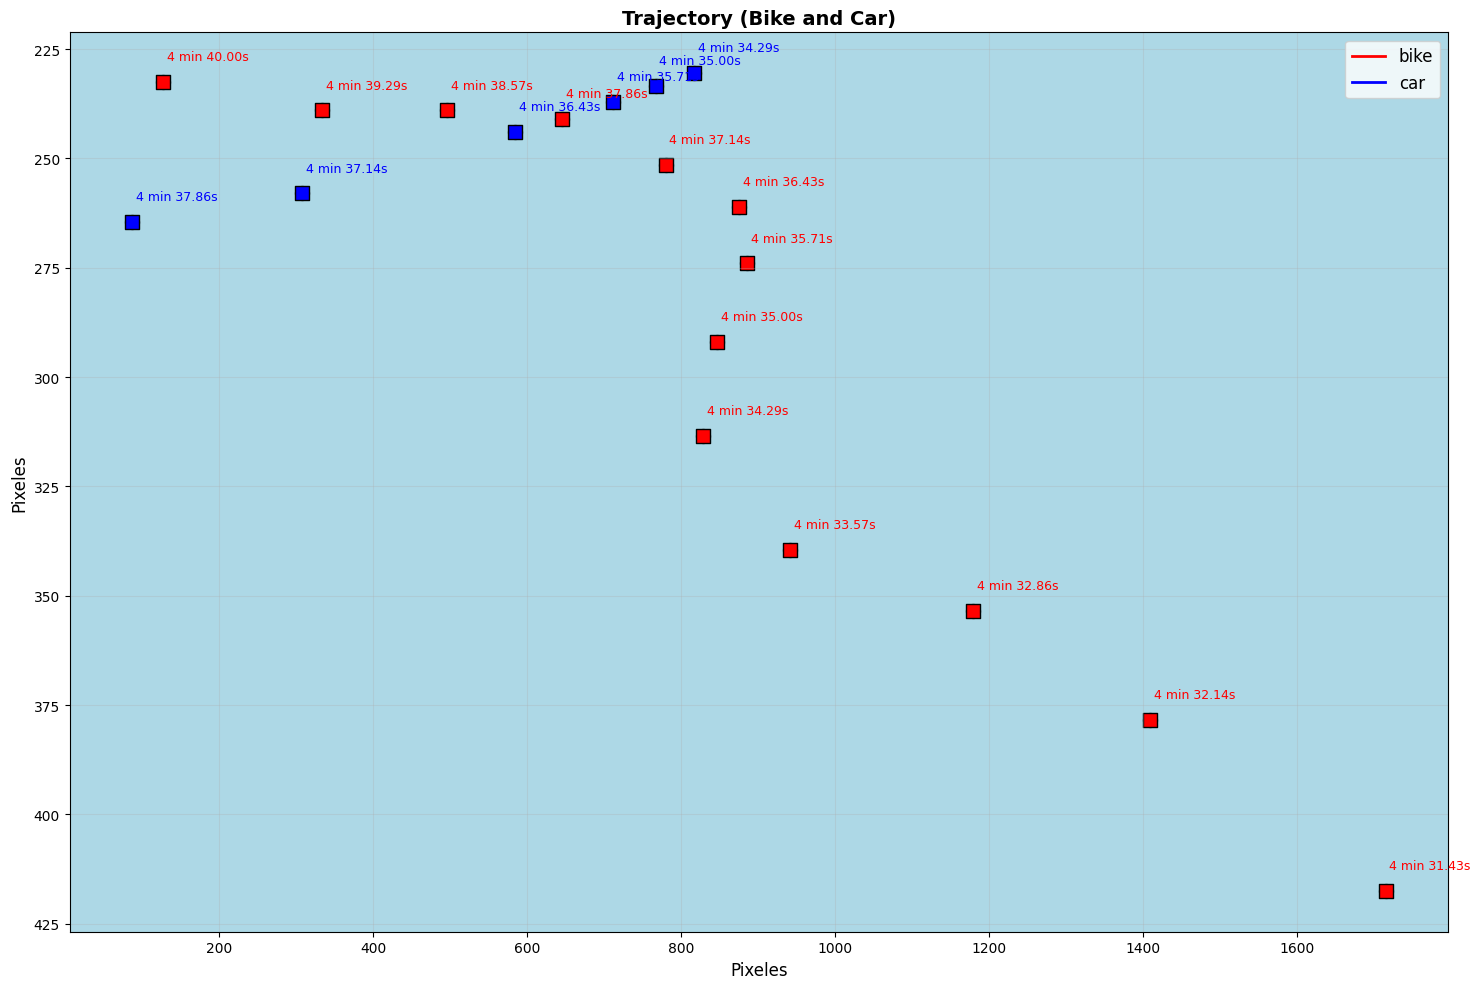

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from config import Config

bike_csv = "./clips/dataset/bounding_boxes_dataset_bike.csv"
car_csv = "./clips/dataset/bounding_boxes_dataset_car.csv"

df_bike = pd.read_csv(bike_csv)
df_bike["object_type"] = "bike"

df_car = pd.read_csv(car_csv)
df_car["object_type"] = "car"

y_threshold = 220
df_car_filtered = df_car[df_car["center_y"] > y_threshold]

df_all = pd.concat([df_bike, df_car_filtered], ignore_index=True)

class TrajectoryVisualizer:
    def __init__(self, df):
        self.df = df
        
    def plot_trajectories(self, figsize=(15, 10), background_color='white', show_boxes=False, show_time=True):
        fig, ax = plt.subplots(figsize=figsize)
        ax.set_facecolor(background_color)

        object_types = self.df["object_type"].unique()
        colors = {"bike": "red", "car": "blue"}

        for obj in object_types:
            df_obj = self.df[self.df["object_type"] == obj]
            for track_id in df_obj["track_id"].unique():
                track_data = df_obj[df_obj["track_id"] == track_id].sort_values("frame_number")

                centers_x = track_data["center_x"].values
                centers_y = track_data["center_y"].values
                timestamps = track_data["timestamp_sec"].values

                ax.plot(centers_x, centers_y, color=colors[obj], linewidth=2, alpha=0.7)
                ax.scatter(centers_x[0], centers_y[0], color=colors[obj], s=100, marker="o", edgecolors="black")
                ax.scatter(centers_x[-1], centers_y[-1], color=colors[obj], s=100, marker="s", edgecolors="black")

                if show_boxes:
                    for _, row in track_data.iterrows():
                        rect = Rectangle((row["x1"], row["y1"]),
                                         row["x2"] - row["x1"],
                                         row["y2"] - row["y1"],
                                         linewidth=1, 
                                         edgecolor=colors[obj],
                                         facecolor="none", alpha=0.3)
                        ax.add_patch(rect)

                if show_time:
                    for x, y, t in zip(centers_x, centers_y, timestamps):
                        ax.text(x + 5, y - 5, f"{Config.minute} min {Config.second + 4 + t:.2f}s", fontsize=9, color=colors[obj])

        ax.set_xlabel("Pixeles", fontsize=12)
        ax.set_ylabel("Pixeles", fontsize=12)
        ax.set_title("Trajectory (Bike and Car)", fontsize=14, fontweight="bold")

        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)

        handles = [plt.Line2D([0], [0], color=colors[obj], lw=2) for obj in object_types]
        labels = [obj for obj in object_types]
        ax.legend(handles, labels, loc="upper right", fontsize=12, framealpha=0.8)

        plt.tight_layout()
        return fig, ax

visualizer = TrajectoryVisualizer(df_all)
fig, ax = visualizer.plot_trajectories(figsize=(15, 10), background_color="lightblue")
plt.show()


In [17]:
df_bike2 = df_bike.drop(columns=["object_type"])

In [16]:
df_bike2.to_json('tracking.json', orient='records')